## Look at who left
### Look at the date of last post
Goals:
1. For each user in the dataset, say when they last posted
2. Show a time-series showing dates of last post

How:
1. Look at data
2. Sort data by username and date
3. Selet the last date for each user-name


In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
import nltk.sentiment.vader
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import community
import time
from sklearn.cluster import SpectralClustering
from sklearn import metrics
%matplotlib inline

//anaconda/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
# dataset = pd.read_csv("csm subforums all posts cleaned.csv")

In [3]:
# dataset.head(10)

In [4]:
# posts = dataset['Post']

In [5]:
# change the date from a string into datetime
# dataset['Date_of_post'] =  pd.to_datetime(dataset['Date_of_post'],infer_datetime_format=True)


In [6]:
# df_sorted = dataset.sort_values(['Username','Date_of_post'], ascending=[True, True])
# df_sorted = df_sorted.reset_index()
# df_sorted.head()

In [7]:
# # look at the distribution in posts per person (maybe per time too?)
# # filter out users who only posted a small numeber of times anyway

# # initialize a new array with number of rows for number of users?
# unique_users = df_sorted['Username'].unique()
# n_users = len(unique_users)


# df_users = pd.DataFrame(index=unique_users, columns = ['Username','num_posts', 'last_post'])
# df_users['last_post']= pd.to_datetime(df_users['last_post'])

    


In [8]:
# df_users.loc['0000hh Baby','last_post']

In [9]:
# users_dict = {}



# last_user = None
# row_idx_first = 0
# row_idx_last = None
# # run thru df_sorted ONCE?
# for index, row in df_sorted.iterrows():
#     user = row['Username']
#     row_idx_last = index
    
#     if user != last_user:
#         row_idx_first = index
    
# # for user in unique_users:
#     users_posts = df_sorted.loc[np.r_[row_idx_first:min(row_idx_last+1,len(df_sorted))], :]
#     num_posts = len(users_posts)
#     last_post = users_posts.tail(1)['Date_of_post'].values[0]
#     first_post = users_posts.head(1)['Date_of_post'].values[0]
    
# #     df_users.loc[user,'Username'] = user
# #     df_users.loc[user,'num_posts'] = num_posts
# #     df_users.loc[user,'last_post'] = last_post
# #     df_users.loc[user,'first_post'] = first_post

#     users_dict[user] = {'num_posts':num_posts,'last_post':last_post,'first_post':first_post}
    
#     if index % 1000 == 0:
#         print(str(index)+"/"+str(len(df_sorted)))
#     last_user = user
    
# users_df = pd.DataFrame.from_dict(users_dict,orient='index')
# # users_df.head(10)

In [10]:
# users_df.to_csv('user_post_count.csv')

In [11]:
users_df = pd.read_csv("user_post_count.csv")

In [12]:
users_df = users_df.reset_index(drop=True)
users_df.head()

,Unnamed: 0,num_posts,last_post,first_post
0,00 heaven,1,2010-12-02,2010-12-02
1,0000hh Baby,1,2010-09-22,2010-09-22
2,00100001,1,2010-11-16,2010-11-16
3,00138921002,1,2010-11-23,2010-11-23
4,00138921821,1,2010-11-23,2010-11-23


(array([  5.73050000e+04,   4.80000000e+01,   1.20000000e+01,
          3.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  1.00000000e+00,   3.98600000e+02,   7.96200000e+02,
          1.19380000e+03,   1.59140000e+03,   1.98900000e+03,
          2.38660000e+03,   2.78420000e+03,   3.18180000e+03,
          3.57940000e+03,   3.97700000e+03]),
 <a list of 10 Patch objects>)

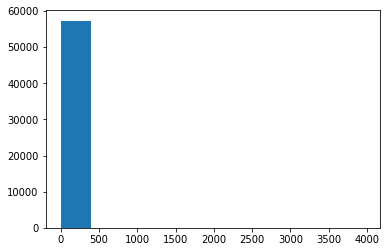

In [13]:
plt.hist(users_df['num_posts'])

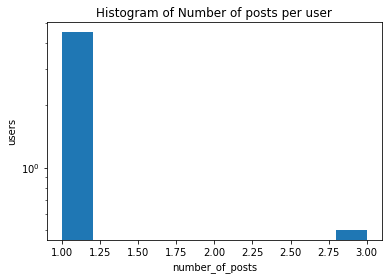

In [14]:
plt.hist(users_df['num_posts'].head(10),log=True,density=True,cumulative=False)
plt.xlabel('number_of_posts')
plt.ylabel('users')
plt.title('Histogram of Number of posts per user')
plt.show()

In [15]:
frequency_table = pd.crosstab(index=users_df['num_posts'], columns="count")


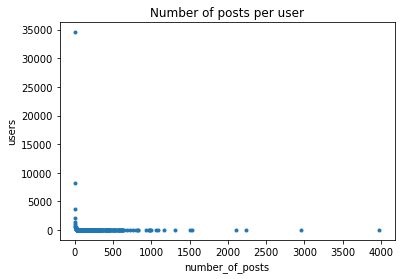

In [16]:
plt.plot(frequency_table,'.')

plt.xlabel('number_of_posts')
plt.ylabel('users')
plt.title('Number of posts per user')
plt.show()

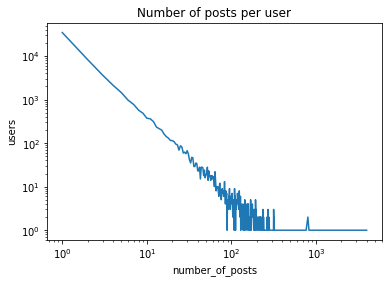

In [17]:
plt.loglog(frequency_table)

plt.xlabel('number_of_posts')
plt.ylabel('users')
plt.title('Number of posts per user')
plt.show()

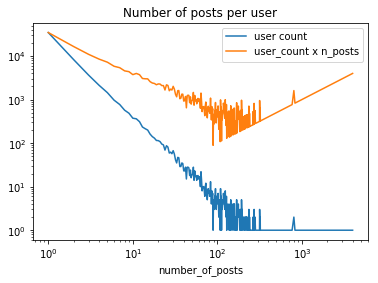

In [18]:
frequency_table['counts_x_users']=frequency_table['count'] * frequency_table.index
plt.loglog(frequency_table)
plt.xlabel('number_of_posts')
plt.legend(['user count','user_count x n_posts'])
plt.title('Number of posts per user')
plt.show()

As can be seen, the VAST majority of people who post in the CSM subforumns only post a few times, with around 10% posting only once (in the CSM subforumns).

To see when people "quit" we need to define who is a "regular". Someone who only posts a few times and then leaves cannot be said to have "quit", rather they were just passing through.

Let's use a cut-off, considering "regulars" to be the most active users whose combined contributions make up 50% of the total posts.
1. rank users by posting volume
2. set-cutoff at 50% total posts

In [19]:
users_df_sorted = users_df.sort_values('num_posts',ascending=False).reset_index(drop=True)
# users_df_sorted
total_posts = sum(users_df['num_posts'])
users_df_sorted['pct_of_posts'] = users_df_sorted['num_posts']/total_posts
users_df_sorted



,Unnamed: 0,num_posts,last_post,first_post,pct_of_posts
0,Herschel Yamamoto,3977,2011-04-19,2008-05-09,0.012480
1,Drake Draconis,2957,2011-09-06,2008-08-13,0.009280
2,malcanis,2240,2017-02-14,2011-09-08,0.007029
3,frying doom,2108,2015-03-11,2012-03-08,0.006615
4,darius mclever,1537,2011-01-03,2009-03-24,0.004823
5,De'Veldrin,1500,2011-09-04,2009-01-29,0.004707
6,Jade Constantine,1313,2011-06-29,2008-03-30,0.004120
7,Bagehi,1170,2011-08-25,2008-09-16,0.003672
8,LaVista Vista,1092,2010-01-29,2008-04-07,0.003427
9,Malcanis,1058,2011-09-04,2008-05-05,0.003320


In [21]:
users_df_sorted['percentile_of_posts']= users_df_sorted['pct_of_posts'].cumsum()

In [466]:
cutoff = 0.50
regular_users = users_df_sorted.loc[users_df_sorted['percentile_of_posts'] < cutoff]
regular_users.tail()

,username,num_posts,last_post,first_post,pct_of_posts,percentile_of_posts
1213,Slickdrac,38,2008-05-29,2008-04-30,0.000119,0.499488
1214,nugget906,38,2011-04-27,2010-06-07,0.000119,0.499608
1215,zagdul,38,2014-12-08,2011-10-07,0.000119,0.499727
1216,Veshta Yoshida,38,2011-06-29,2009-05-14,0.000119,0.499846
1217,cBOLTSON,38,2011-06-27,2009-07-27,0.000119,0.499965


In [437]:
frequency_table_started = pd.crosstab(index=users_df['first_post'], columns="count")
frequency_table_left = pd.crosstab(index=users_df['last_post'], columns="count")



In [438]:
try:
    regular_users["last_post"] = regular_users["last_post"].astype("datetime64[ns]")
except:
    pass


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [439]:
regular_users["first_post"] = regular_users["first_post"].astype("datetime64[ns]")
regular_users

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,username,num_posts,last_post,first_post,pct_of_posts,percentile_of_posts
0,Herschel Yamamoto,3977,2011-04-19,2008-05-09,0.012480,0.012480
1,Drake Draconis,2957,2011-09-06,2008-08-13,0.009280,0.021760
2,malcanis,2240,2017-02-14,2011-09-08,0.007029,0.028789
3,frying doom,2108,2015-03-11,2012-03-08,0.006615,0.035405
4,darius mclever,1537,2011-01-03,2009-03-24,0.004823,0.040228
5,De'Veldrin,1500,2011-09-04,2009-01-29,0.004707,0.044935
6,Jade Constantine,1313,2011-06-29,2008-03-30,0.004120,0.049056
7,Bagehi,1170,2011-08-25,2008-09-16,0.003672,0.052727
8,LaVista Vista,1092,2010-01-29,2008-04-07,0.003427,0.056154
9,Malcanis,1058,2011-09-04,2008-05-05,0.003320,0.059474


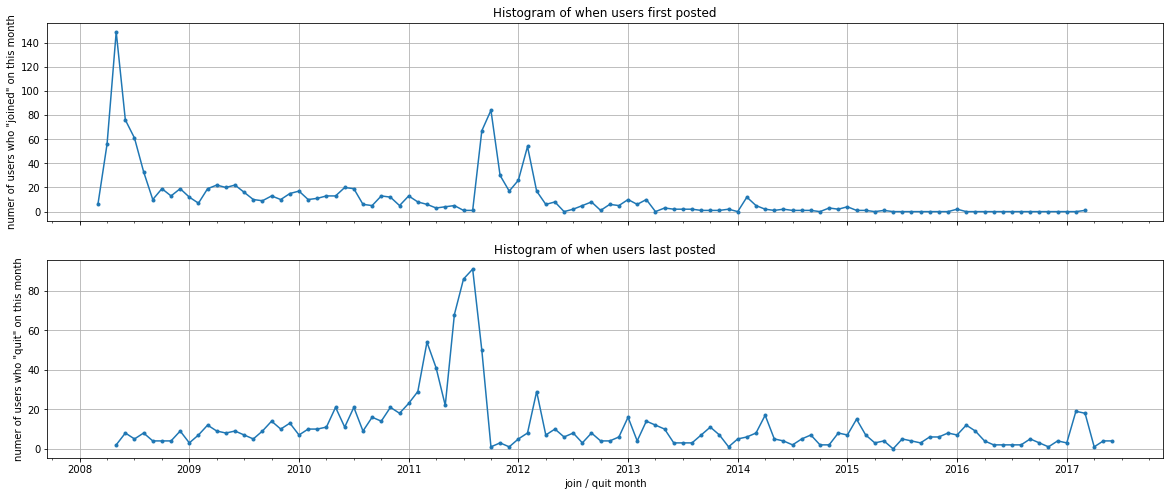

In [440]:
plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')

y = regular_users
try:
    y=regular_users['last_post'].astype("datetime64")
    y=regular_users['first_post'].astype("datetime64")
except:
    print('')

ax1 = plt.subplot(212)
regular_users.groupby(pd.Grouper(key='last_post',freq="1M")).count()['username'].plot(marker='.')

plt.xlabel('join / quit month')
plt.ylabel('numer of users who "quit" on this month')
plt.title('Histogram of when users last posted')
plt.grid(True)

###

ax2 = plt.subplot(211, sharex=ax1)
regular_users.groupby(pd.Grouper(key='first_post',freq="1M")).count()['username'].plot(marker='.')
plt.ylabel('numer of users who "joined" on this month')
plt.title('Histogram of when users first posted')
plt.grid(True)


This looks like there was a large escalation of people leaving during the Incarna crisis, as well as a lot of people joining the CSM forums for the first time during the crisis.

Let's reproduce this graph for all users above the threshold (not filtering by date).

In [ ]:
plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')

y = regular_users
try:
    y=regular_users['last_post'].astype("datetime64")
    y=regular_users['first_post'].astype("datetime64")
except:
    print('')

ax1 = plt.subplot(212)
regular_users.groupby(pd.Grouper(key='last_post',freq="1M")).count()['username'].plot(marker='.')

plt.xlabel('join / quit month')
plt.ylabel('numer of users who "quit" on this month')
plt.title('Histogram of when users last posted')
plt.grid(True)

###

ax2 = plt.subplot(211, sharex=ax1)
regular_users.groupby(pd.Grouper(key='first_post',freq="1M")).count()['username'].plot(marker='.')
plt.ylabel('numer of users who "joined" on this month')
plt.title('Histogram of when users first posted')
plt.grid(True)


Let's see if the trend holds if we move the cutoff to top posters contributing 60% of posts

In [368]:
cutoff = 0.60 # top percent of posts
regular_users = users_df_sorted.loc[users_df_sorted['percentile_of_posts'] < cutoff]

regular_users

,username,num_posts,last_post,first_post,pct_of_posts,percentile_of_posts
0,Herschel Yamamoto,3977,2011-04-19,2008-05-09,0.012480,0.012480
1,Drake Draconis,2957,2011-09-06,2008-08-13,0.009280,0.021760
2,malcanis,2240,2017-02-14,2011-09-08,0.007029,0.028789
3,frying doom,2108,2015-03-11,2012-03-08,0.006615,0.035405
4,darius mclever,1537,2011-01-03,2009-03-24,0.004823,0.040228
5,De'Veldrin,1500,2011-09-04,2009-01-29,0.004707,0.044935
6,Jade Constantine,1313,2011-06-29,2008-03-30,0.004120,0.049056
7,Bagehi,1170,2011-08-25,2008-09-16,0.003672,0.052727
8,LaVista Vista,1092,2010-01-29,2008-04-07,0.003427,0.056154
9,Malcanis,1058,2011-09-04,2008-05-05,0.003320,0.059474


//anaconda/lib/python3.5/site-packages/pandas/core/internals.py:3462: FutureWarning: Passing in 'datetime64' dtype with no frequency is deprecated and will raise in a future version. Please pass in 'datetime64[ns]' instead.
  return self.apply('astype', dtype=dtype, **kwargs)
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


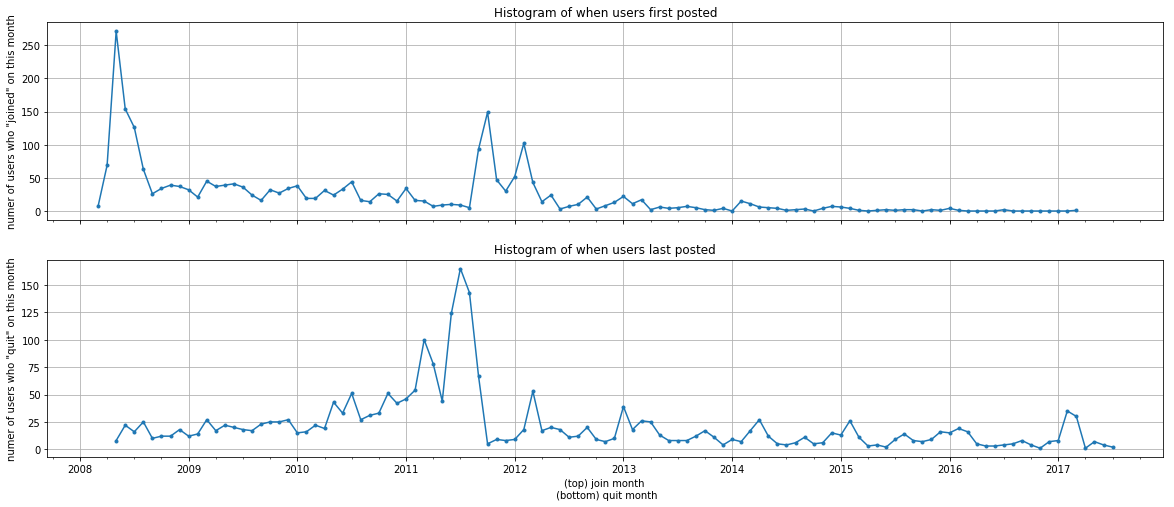

In [369]:

plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')

# y = regular_users
try:
    regular_users['last_post']=regular_users['last_post'].astype("datetime64[ns]")
    regular_users['first_post']=regular_users['first_post'].astype("datetime64[ns]")
except:
    print('')

ax1 = plt.subplot(212)
regular_users.groupby(pd.Grouper(key='last_post',freq="1M")).count()['username'].plot(marker='.')

plt.xlabel('(top) join month \n (bottom) quit month')
plt.ylabel('numer of users who "quit" on this month')
plt.title('Histogram of when users last posted')
plt.grid(True)

###

ax2 = plt.subplot(211, sharex=ax1)
regular_users.groupby(pd.Grouper(key='first_post',freq="1M")).count()['username'].plot(marker='.')
plt.ylabel('numer of users who "joined" on this month')
plt.title('Histogram of when users first posted')
plt.grid(True)


Looks like the trend holds more or less - but this is picking up people who posted only 19 times in the CSM forums, so it is probably much less representative of "regulars."

In [370]:
# frequency_table_started = pd.crosstab(index=users_df['first_post'], columns="count")
# frequency_table_left = pd.crosstab(index=users_df['last_post'], columns="count")



In [371]:
# regular_users["last_post"] = regular_users["last_post"].astype("datetime64")


In [365]:
# regular_users["first_post"] = regular_users["first_post"].astype("datetime64")


------------------------

Goals:
See the difference between those who stayed vs. left during the crisis

Steps:
1. Filter out those who JOINED after the crisis or LEFT well before the crisis.
2. Compare those who left vs. stayed along various metrics

In [211]:
users_df_sorted.columns = ["username","num_posts","last_post","first_post","pct_of_posts",'percentile_of_posts']


In [426]:
crisis_end = "2011-12-01" # posted before.... look at people who did not joing AFTER the crisis
crisis_start = "2011-01-01" # posted after.... look at ppl who did not leave BEFORE the crisis

users_of_interest = users_df_sorted.loc[(users_df_sorted['first_post']<crisis_end) & (users_df_sorted['last_post']>crisis_start)]


# re-calculate percentiles for these users

users_of_interest['pct_of_posts'] = users_of_interest['num_posts']/sum(users_of_interest['num_posts'])
users_of_interest['percentile_of_posts']= users_of_interest['pct_of_posts'].cumsum()

cutoff = 0.75 # top percent of posts
regular_users = users_of_interest.loc[users_of_interest['percentile_of_posts'] < cutoff]

# regular_users

# plt.hist(regular_users['num_posts'],log=True)

left_during_crisis = regular_users.loc[users_of_interest['last_post']<crisis_end]
remained_after_crisis = regular_users.loc[users_of_interest['last_post']>=crisis_end]

print("left_during_crisis: "+ str(len(left_during_crisis)))
print("remained_after_crisis: " + str( len(remained_after_crisis)))
print("cutoff number of posts: "+ str(min(regular_users['num_posts'])))




//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


left_during_crisis: 793
remained_after_crisis: 304
cutoff number of posts: 21


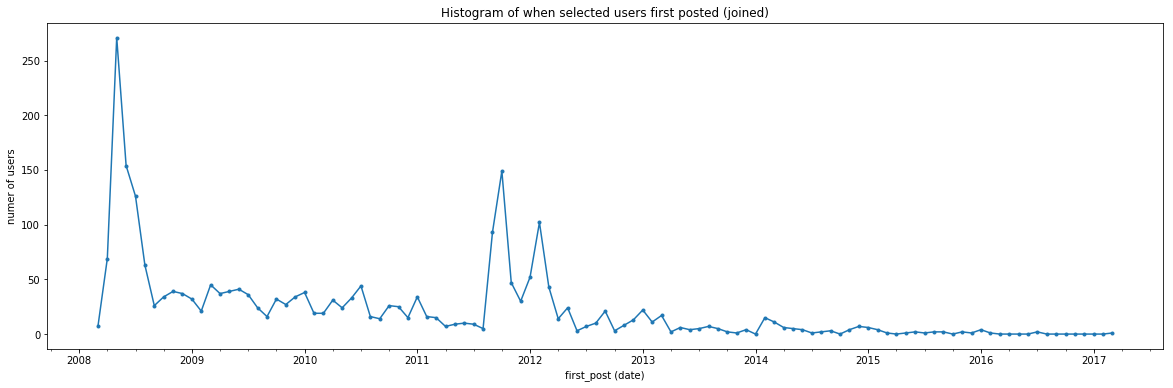

In [373]:
try:
    first_posts = regular_users["first_post"].astype("datetime64")
except:
    pass

plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')

regular_users.groupby(pd.Grouper(key='first_post',freq="1M")).count()['username'].plot(marker='.')

#                  ,log=True,density=True,cumulative=False)
plt.xlabel('first_post (date)')
plt.ylabel('numer of users')
plt.title('Histogram of when selected users first posted (joined)')
plt.show()

This is good - it looks like we have a good distribution of people who joined the CSM subforum before the crisis, and some who joined right during the crisis as well.

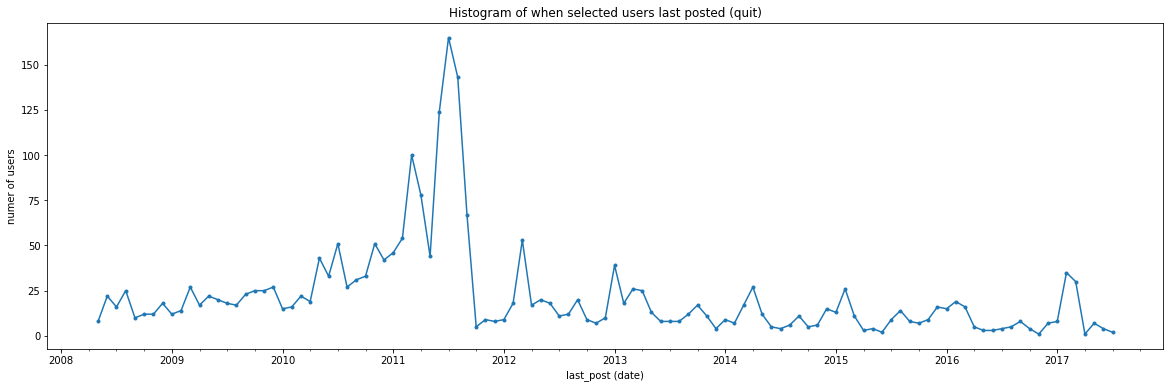

In [376]:
try:
    last_posts = regular_users["last_post"].astype("datetime64")
except:
    pass

plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')

regular_users.groupby(pd.Grouper(key='last_post',freq="1M")).count()['username'].plot(marker='.')

plt.xlabel('last_post (date)')
plt.ylabel('numer of users')
plt.title('Histogram of when selected users last posted (quit)')
plt.show()


This graph shows that there was an escalation of people leaving thru the summer, but that there is still a contingent that was there early on, and remained posting even later on.

Now, we have our two lists of people.

We need to distinguish them somehow.

To distinguish the two groups we need to think about what constructs or processes (measures) we want to apply to the two groups to distinguish them. 

This gives us two parallel tasks:
1. Think about what theory exists and would EXPECT to be a factor / process. (e.g. centrality, etc.)
2. Look more qualitatively and see if we are inspired.

First, let's see if theory holds here- if not, we don't have an open question - we have a ready-made explanation of why/how people leave.

What theoy / factors might apply? What do we expect?
1. Those whose __identity__ is strongly affected by the changes leave. Look at those posters who emphasize enjoying aspects of the game that are being changed (e.g. 'flying in space').
2. Users who post most are likely to stay (they are the most habituated / committed)
3. Users without "strong ties" are more likely to leave. (but in online world, do you look at ties to particular users? Or to topics / threads?)
4. "Centrality" in the community will either strongly predict staying or leaving. Probably staying.
5. Those who are most "angry" (negative sentiment) are most likely to leave.
6. Users who posted more about certain topics or in certain ways (e.g. those who were ASKING for things, or petitioning the company are most likely to leave.)

We also have the LIWC on each posting. We can average these across postings for each user in our subset to get those co-variates, and if any seem strong investigate it qualitatively to see if it makes sense. Not theoretically-motivated per-se but there might be a reason people chose those measures.

For this to be more "GTM" we might try first to hand-code more of these user's posts to get a sense of what is going on first before using out-of-the-box metrics. Looking qualitatively may inherently spot what is "intersting" while simultaneously getting a richer sense of the scene.

But also there are time limits to this work. 

Let's spend a little time looking at the posts qualitatively in context. 
1. Select some of the top-top posters (with thousands of posts), some of the lower-limit of our sample (20ish posts), and the "median" regular in our sample (50-70 posts). 
2. For each of these users, look at the threads they posted in, and "follow" them from thread to thread to see what they are saying.

### Selecting posts of the top-top users.
Who are these mega-users?

What are they posting about?

In [378]:
regular_users.columns = ["username","num_posts","last_post","first_post","pct_of_posts",'percentile_of_posts']
regular_users.head(10)

,username,num_posts,last_post,first_post,pct_of_posts,percentile_of_posts
0,Herschel Yamamoto,3977,2011-04-19,2008-05-09,0.012480,0.012480
1,Drake Draconis,2957,2011-09-06,2008-08-13,0.009280,0.021760
2,malcanis,2240,2017-02-14,2011-09-08,0.007029,0.028789
3,frying doom,2108,2015-03-11,2012-03-08,0.006615,0.035405
4,darius mclever,1537,2011-01-03,2009-03-24,0.004823,0.040228
5,De'Veldrin,1500,2011-09-04,2009-01-29,0.004707,0.044935
6,Jade Constantine,1313,2011-06-29,2008-03-30,0.004120,0.049056
7,Bagehi,1170,2011-08-25,2008-09-16,0.003672,0.052727
8,LaVista Vista,1092,2010-01-29,2008-04-07,0.003427,0.056154
9,Malcanis,1058,2011-09-04,2008-05-05,0.003320,0.059474


In [ ]:
# import all the data again, and filter for the users of interest.

dataset = pd.read_csv("csm subforums all posts cleaned.csv")

In [385]:
dataset['Date_of_post']=dataset['Date_of_post'].astype("datetime64[ns]")

In [386]:
user_of_interest = "Herschel Yamamoto"
users_posts = dataset.loc[dataset['Username']==user_of_interest,:].sort_values("Date_of_post")
users_posts

,Unnamed: 0,ID,Subforum,subsectionpage,all_thread_ids,Thread_Title,Thread_Page,Date_of_post,Username,Post,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
211295,211296,223234,Jita Park Speakers Corner,51,759968,[csm candidate] jade constantine,7,2008-05-09,Herschel Yamamoto,i've already voted for you - your vision for t...,...,"3,29","0,00","0,00","0,94","0,00","1,41","0,94","4,23","0,00","0,00"
173719,173720,184719,Assembly Hall,265,777791,[issue] this forum needs a thumbs down option ...,1,2008-05-22,Herschel Yamamoto,"agreed, both with op and quoted.",...,"16,67","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
174652,174653,185733,Assembly Hall,266,777872,[issue] the nighthawk needs a powergrid increase,1,2008-05-22,Herschel Yamamoto,i just ran it up in eft. hams up the dps to 45...,...,"5,80","0,00","0,00","0,00","0,00","0,72","0,00","2,17","1,45","0,72"
173875,173876,184902,Assembly Hall,265,777935,[issue] detialed rebalancing of ship classes/r...,1,2008-05-22,Herschel Yamamoto,there anything in particular you had in mind? ...,...,"3,03","0,00","0,00","3,03","0,00","3,03","0,00","0,00","0,00","0,00"
181681,181682,193286,Assembly Hall,281,777927,alternate fund raising methods than increasing...,1,2008-05-22,Herschel Yamamoto,link to the gtc price increase?,...,"0,00","0,00","0,00","16,67","0,00","0,00","0,00","0,00","0,00","0,00"
147814,147815,157349,Assembly Hall,231,777834,[issue] regular cloaking devices need nerfing,1,2008-05-22,Herschel Yamamoto,how the hell is bacon relevant to this argumen...,...,"12,82","0,00","0,00","2,56","2,56","0,00","0,00","2,56","0,00","0,00"
170969,170970,181798,Assembly Hall,262,777841,[issue] remove agent qualities,1,2008-05-22,Herschel Yamamoto,"if you're referring to the mess in motsu, aram...",...,"6,76","0,00","0,00","0,00","0,00","0,00","0,00","5,41","0,00","1,35"
152409,152410,162163,Assembly Hall,241,777866,[issue] removal of 30-day and 90-day time cards,1,2008-05-22,Herschel Yamamoto,i haven't seen anything on this topic except i...,...,"0,00","0,00","0,00","5,88","0,00","0,00","0,00","5,88","0,00","0,00"
152417,152418,162171,Assembly Hall,241,777866,[issue] removal of 30-day and 90-day time cards,2,2008-05-22,Herschel Yamamoto,deleting 50- and 100-day cards makes sense. ra...,...,"3,75","0,00","0,00","1,25","0,00","5,00","0,00","6,25","2,50","2,50"
170522,170523,181326,Assembly Hall,262,777772,[issue] votes of no confidence in csm director,2,2008-05-22,Herschel Yamamoto,the post i was responding to was basically a p...,...,"5,56","0,00","0,00","0,00","0,00","1,85","3,70","1,85","0,00","0,00"


In [387]:
# pd.crosstab(index=users_posts['Subforum'], columns=["count"])

In [388]:
# x = pd.crosstab(index=users_posts['Thread_Title'], columns=["count"])
# print('number of posts per thread by ' + user_of_interest)
# pd.crosstab(index=x['count'], columns=["count"])

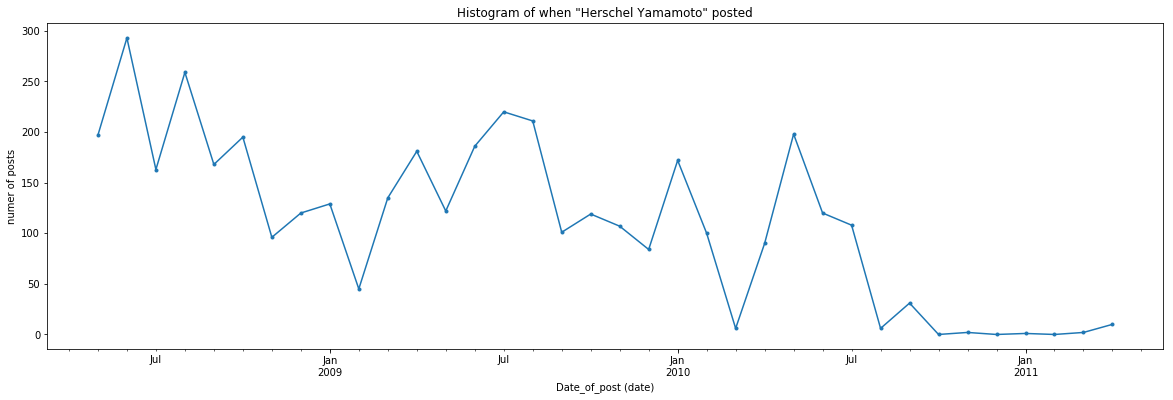

In [391]:
# date_of_post = users_posts["Date_of_post"].astype("datetime64")

plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')

users_posts.groupby(pd.Grouper(key='Date_of_post',freq="1M")).count()['Username'].plot(marker='.')

plt.xlabel('Date_of_post (date)')
plt.ylabel('numer of posts')
plt.title('Histogram of when \"'+user_of_interest+'\" posted')
plt.show()


It looks like Herschel Yamamoto mostly stopped posting before the "crisis". Let's look at another user.

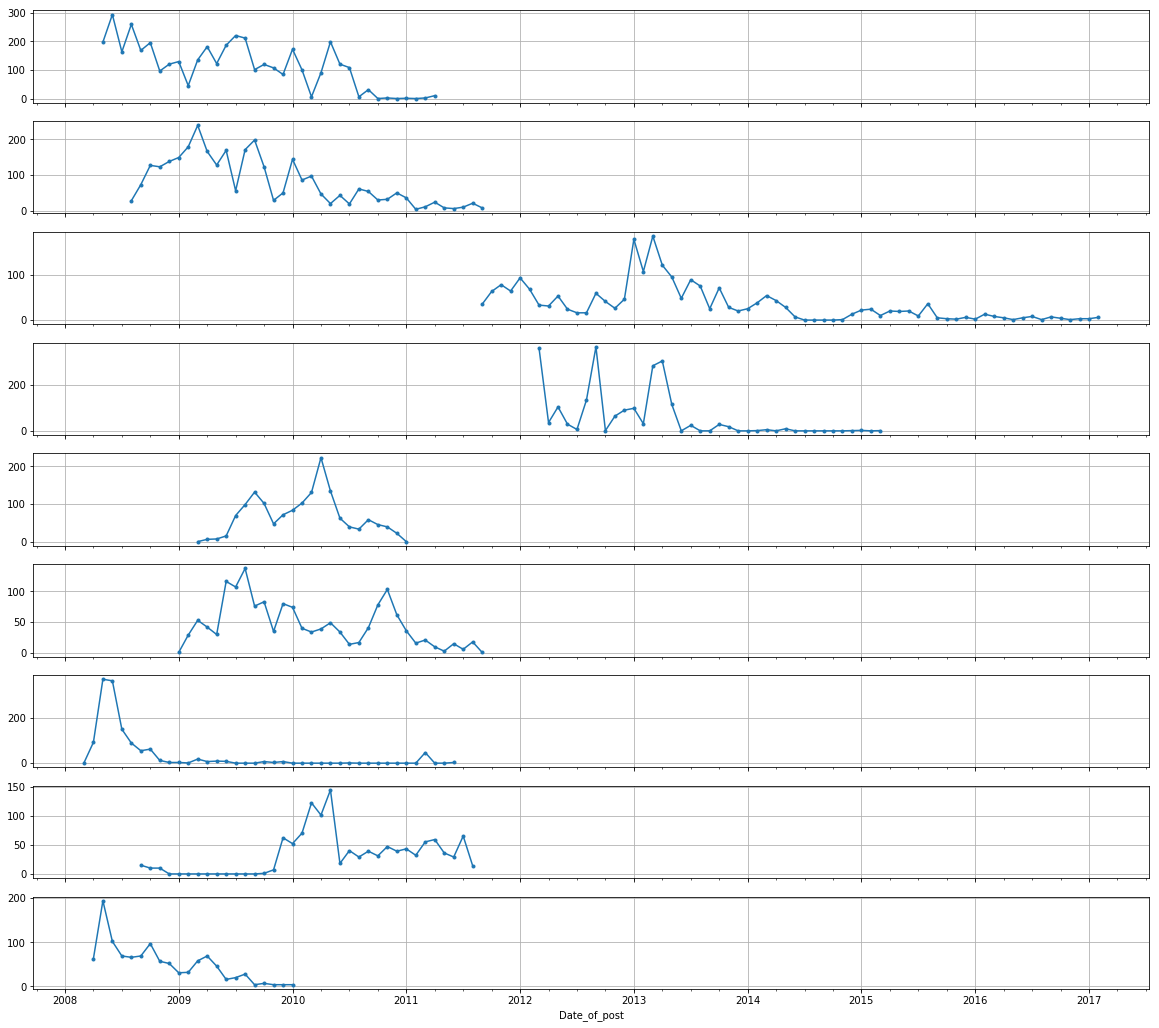

In [403]:
# let's just do a multi-plot with all the top-posters and see what we see


top_n = 9


plt.figure(num=None, figsize=(20, top_n*2), dpi=80, facecolor='w', edgecolor='k')


counter = 0

ax = [0]*top_n

for user_of_interest in regular_users['username'].head(top_n):
    ax[counter] = plt.subplot(top_n*100+11+counter)
    if counter > 0:
        ax[counter] = plt.subplot(top_n*100+11+counter,sharex=ax[0])
    users_posts = dataset.loc[dataset['Username']==user_of_interest,:].sort_values("Date_of_post")
    users_posts.groupby(pd.Grouper(key='Date_of_post',freq="1M")).count()['Username'].plot(marker='.')
    
    counter += 1 #### stopped editing here!
    plt.grid(True)
plt.show()


# # y = regular_users
# try:
#     regular_users['last_post']=regular_users['last_post'].astype("datetime64[ns]")
#     regular_users['first_post']=regular_users['first_post'].astype("datetime64[ns]")
# except:
#     print('')

# ax1 = plt.subplot(212)
# regular_users.groupby(pd.Grouper(key='last_post',freq="1M")).count()['username'].plot(marker='.')

# plt.xlabel('(top) join month \n (bottom) quit month')
# plt.ylabel('numer of users who "quit" on this month')
# plt.title('Histogram of when users last posted')
# plt.grid(True)

# ###

# ax2 = plt.subplot(211, sharex=ax1)
# regular_users.groupby(pd.Grouper(key='first_post',freq="1M")).count()['username'].plot(marker='.')
# plt.ylabel('numer of users who "joined" on this month')
# plt.title('Histogram of when users first posted')
# plt.grid(True)

In [404]:
user_of_interest = "Drake Draconis"
users_posts = dataset.loc[dataset['Username']==user_of_interest,:].sort_values("Date_of_post")
# users_posts

In [405]:
pd.crosstab(index=users_posts['Subforum'], columns=["count"])

col_0,count
Subforum,
Assembly Hall,2906
Jita Park Speakers Corner,51


In [406]:
# x = pd.crosstab(index=users_posts['Thread_Title'], columns=["count"])
# print('number of posts per thread by ' + user_of_interest)
# pd.crosstab(index=x['count'], columns=["count"])

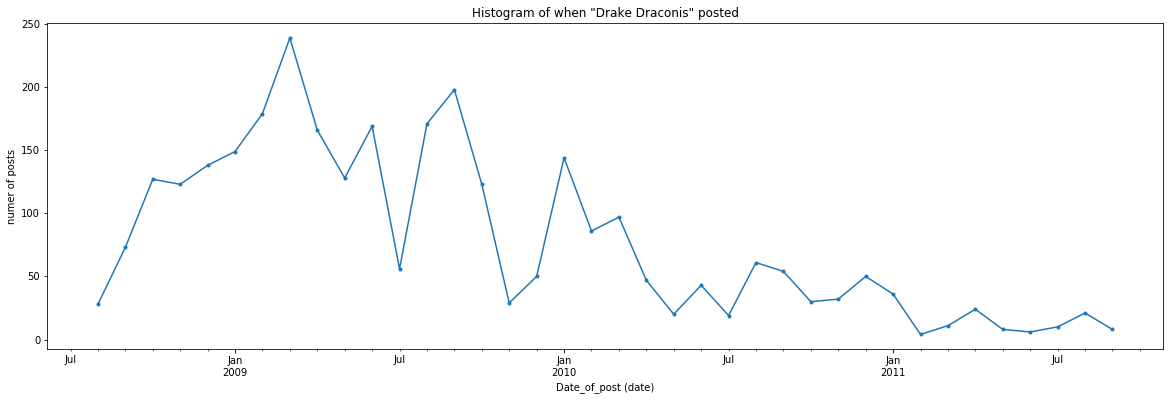

In [409]:
plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')

users_posts.groupby(pd.Grouper(key='Date_of_post',freq="1M")).count()['Username'].plot(marker='.')
#                  ,log=True,density=True,cumulative=False)
plt.xlabel('Date_of_post (date)')
plt.ylabel('numer of posts')
plt.title('Histogram of when \"'+user_of_interest+'\" posted')
plt.show()


Interesting. This user also started strong around 2009 and then petered out in 2010, finally quitting in Sept 2011. This may be a good user to investigate more. Let's look at a few more super-users before moving onto the "minnows".

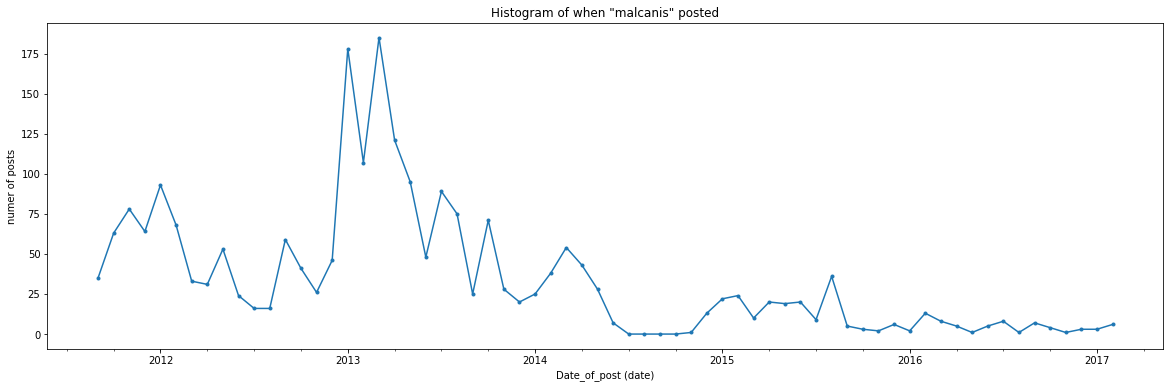

In [412]:
user_of_interest = "malcanis"
users_posts = dataset.loc[dataset['Username']==user_of_interest,:].sort_values("Date_of_post")
# users_posts

plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')

users_posts.groupby(pd.Grouper(key='Date_of_post',freq="1M")).count()['Username'].plot(marker='.')
#                  ,log=True,density=True,cumulative=False)
plt.xlabel('Date_of_post (date)')
plt.ylabel('numer of posts')
plt.title('Histogram of when \"'+user_of_interest+'\" posted')
plt.show()


This user "malcanis" only started poting AFTER the bulk of the crisis (Sept 2011) and continued posting the entire time.



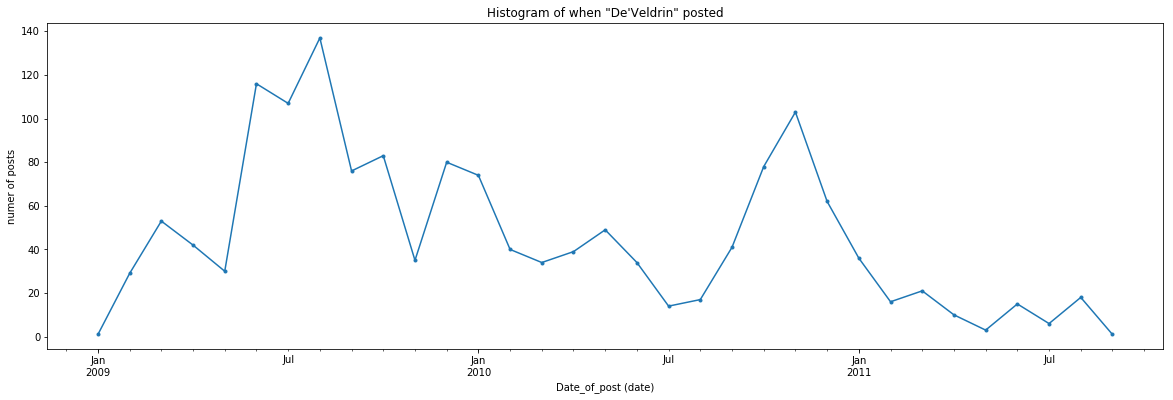

In [411]:
user_of_interest = "De\'Veldrin"
users_posts = dataset.loc[dataset['Username']==user_of_interest,:].sort_values("Date_of_post")
# users_posts

plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')

users_posts.groupby(pd.Grouper(key='Date_of_post',freq="1M")).count()['Username'].plot(marker='.')
#                  ,log=True,density=True,cumulative=False)
plt.xlabel('Date_of_post (date)')
plt.ylabel('numer of posts')
plt.title('Histogram of when \"'+user_of_interest+'\" posted')
plt.show()


This looks like what we might expect - a user who was posting more during the prior times, and who posted less and less during the crisis, before finally "quitting" in Sept 2011.

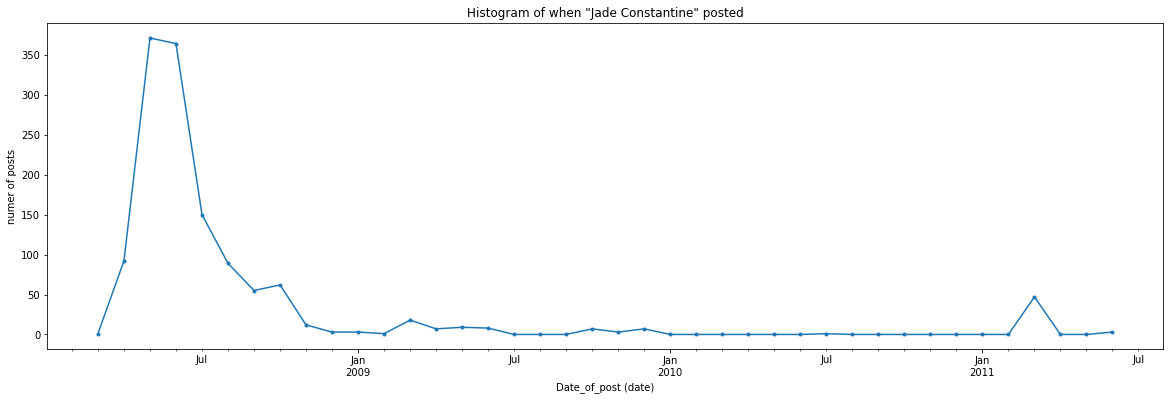

In [413]:
user_of_interest = "Jade Constantine"
users_posts = dataset.loc[dataset['Username']==user_of_interest,:].sort_values("Date_of_post")

plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')

users_posts.groupby(pd.Grouper(key='Date_of_post',freq="1M")).count()['Username'].plot(marker='.')
#                  ,log=True,density=True,cumulative=False)
plt.xlabel('Date_of_post (date)')
plt.ylabel('numer of posts')
plt.title('Histogram of when \"'+user_of_interest+'\" posted')
plt.show()

Another with early involvement, then petering out, before finally leaving in 2011 (July).

It may be that some who left were just getting bored with the game in general. Let's now look at a few users in the middle (50% of posts)

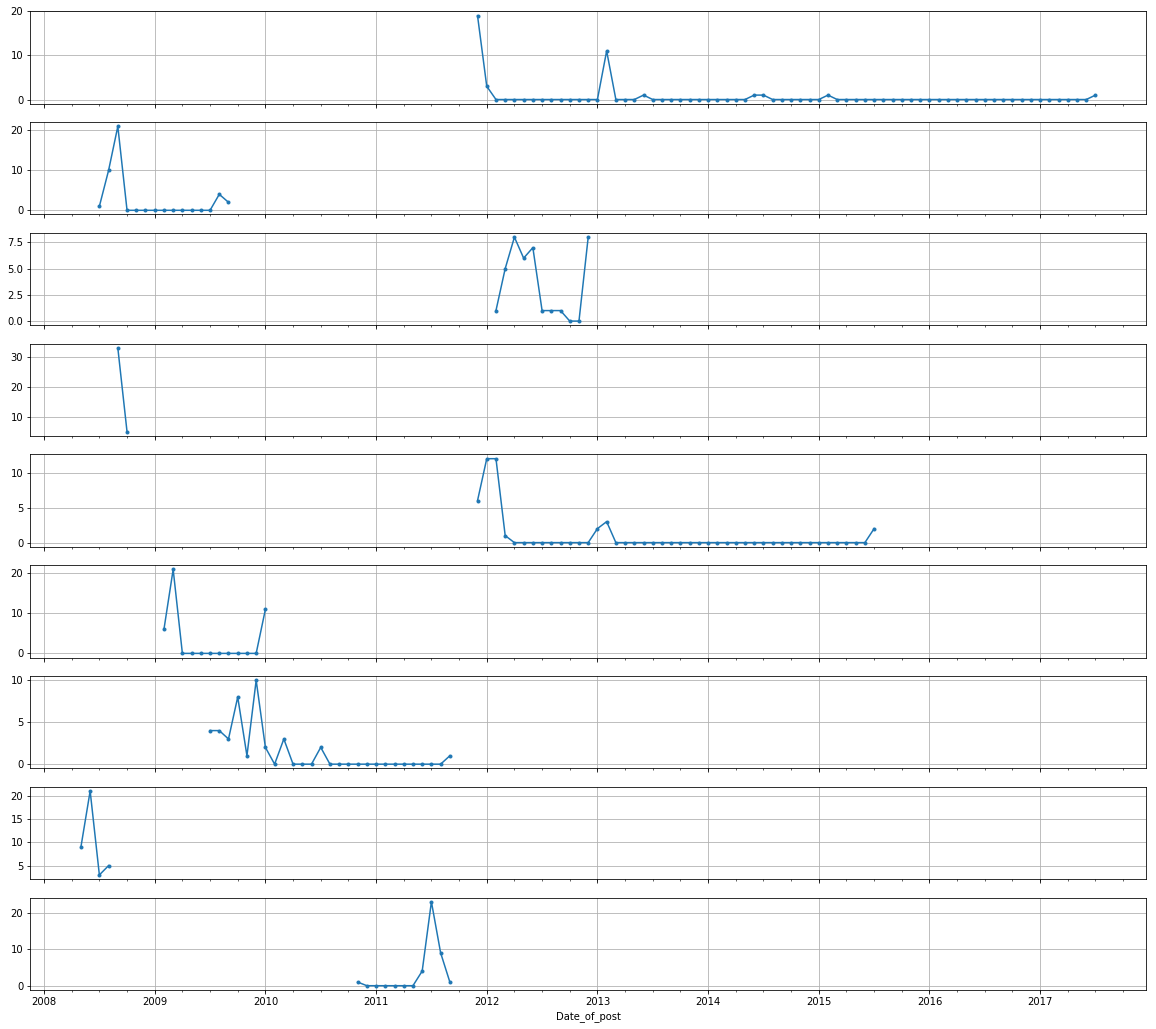

In [422]:
# look at what trajectories of the users closer to the 50th percentile (of posts) looked like


top_n = 9


plt.figure(num=None, figsize=(20, top_n*2), dpi=80, facecolor='w', edgecolor='k')


counter = 0

ax = [0]*top_n

for user_of_interest in regular_users.loc[regular_users['percentile_of_posts']>.50].head(top_n)['username']:
    ax[counter] = plt.subplot(top_n*100+11+counter)
    if counter > 0:
        ax[counter] = plt.subplot(top_n*100+11+counter,sharex=ax[0])
    users_posts = dataset.loc[dataset['Username']==user_of_interest,:].sort_values("Date_of_post")
    users_posts.groupby(pd.Grouper(key='Date_of_post',freq="1M")).count()['Username'].plot(marker='.')
    
    counter += 1 #### stopped editing here!
    plt.grid(True)
plt.show()


### Look for difference between those who left and stayed.

Really, we probably shouldn't just be using the time-series alone - unless motivated theoretically by this (Should we?) is it a case of low-hanging fruit?

In [419]:
left_during_crisis.rename({'Unnamed: 0':'username'})
left_during_crisis.head()

remained_after_crisis.head()

,username,num_posts,last_post,first_post,pct_of_posts,percentile_of_posts
2,malcanis,2240,2017-02-14,2011-09-08,0.014596,0.059779
10,lord zim,995,2013-11-12,2011-10-25,0.006484,0.109126
13,drake draconis,971,2012-05-31,2011-09-15,0.006327,0.121865
21,issler dainze,677,2014-03-31,2011-09-28,0.004411,0.147832
22,andski,641,2017-01-28,2011-09-14,0.004177,0.152009


#### Who remaind after the crisis

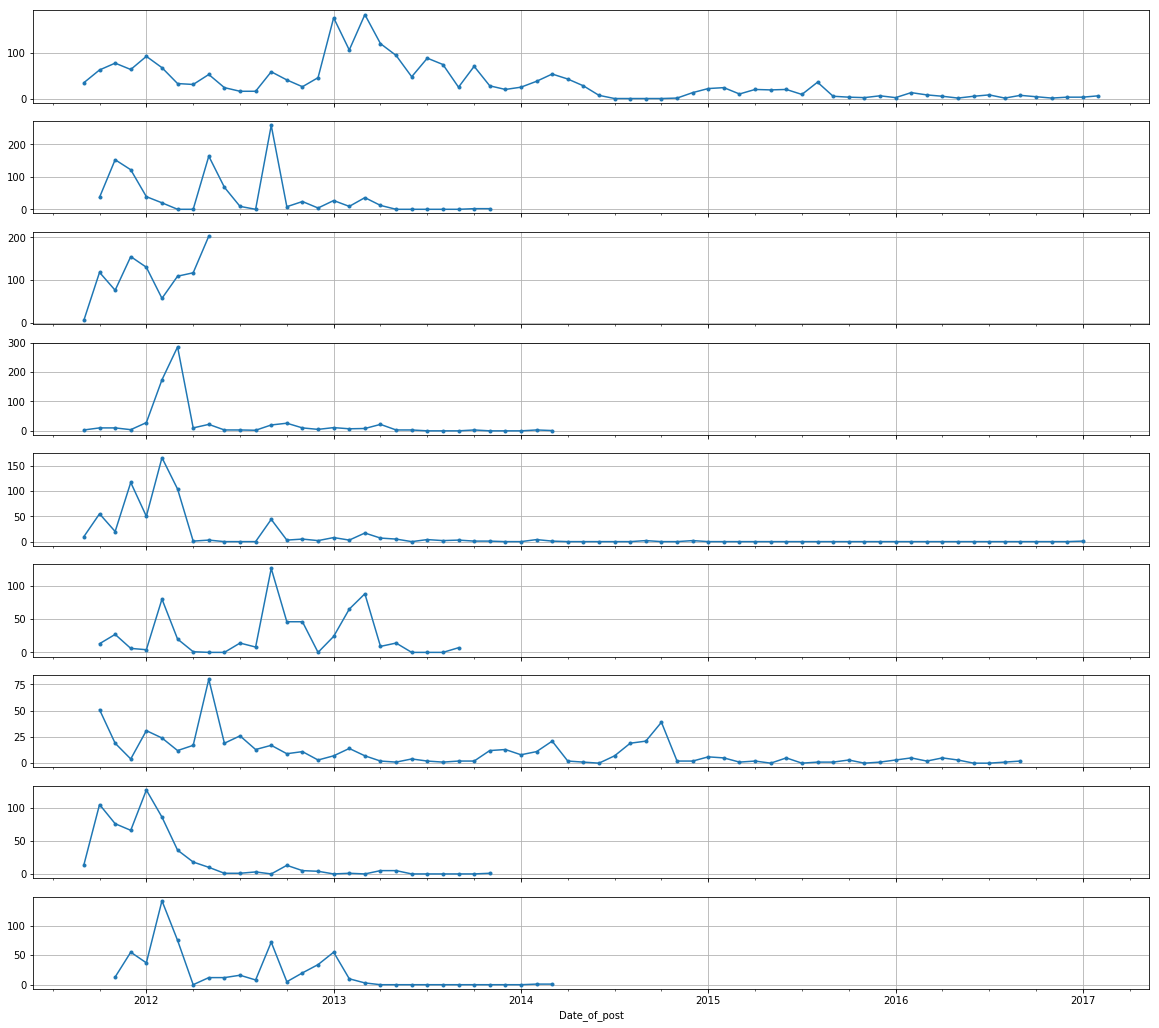

In [425]:
# top users


top_n = 9


plt.figure(num=None, figsize=(20, top_n*2), dpi=80, facecolor='w', edgecolor='k')


counter = 0

ax = [0]*top_n

for user_of_interest in remained_after_crisis.head(top_n)['username']:
    ax[counter] = plt.subplot(top_n*100+11+counter)
    if counter > 0:
        ax[counter] = plt.subplot(top_n*100+11+counter,sharex=ax[0])
    users_posts = dataset.loc[dataset['Username']==user_of_interest,:].sort_values("Date_of_post")
    users_posts.groupby(pd.Grouper(key='Date_of_post',freq="1M")).count()['Username'].plot(marker='.')
    
    counter += 1 #### stopped editing here!
    plt.grid(True)
plt.show()


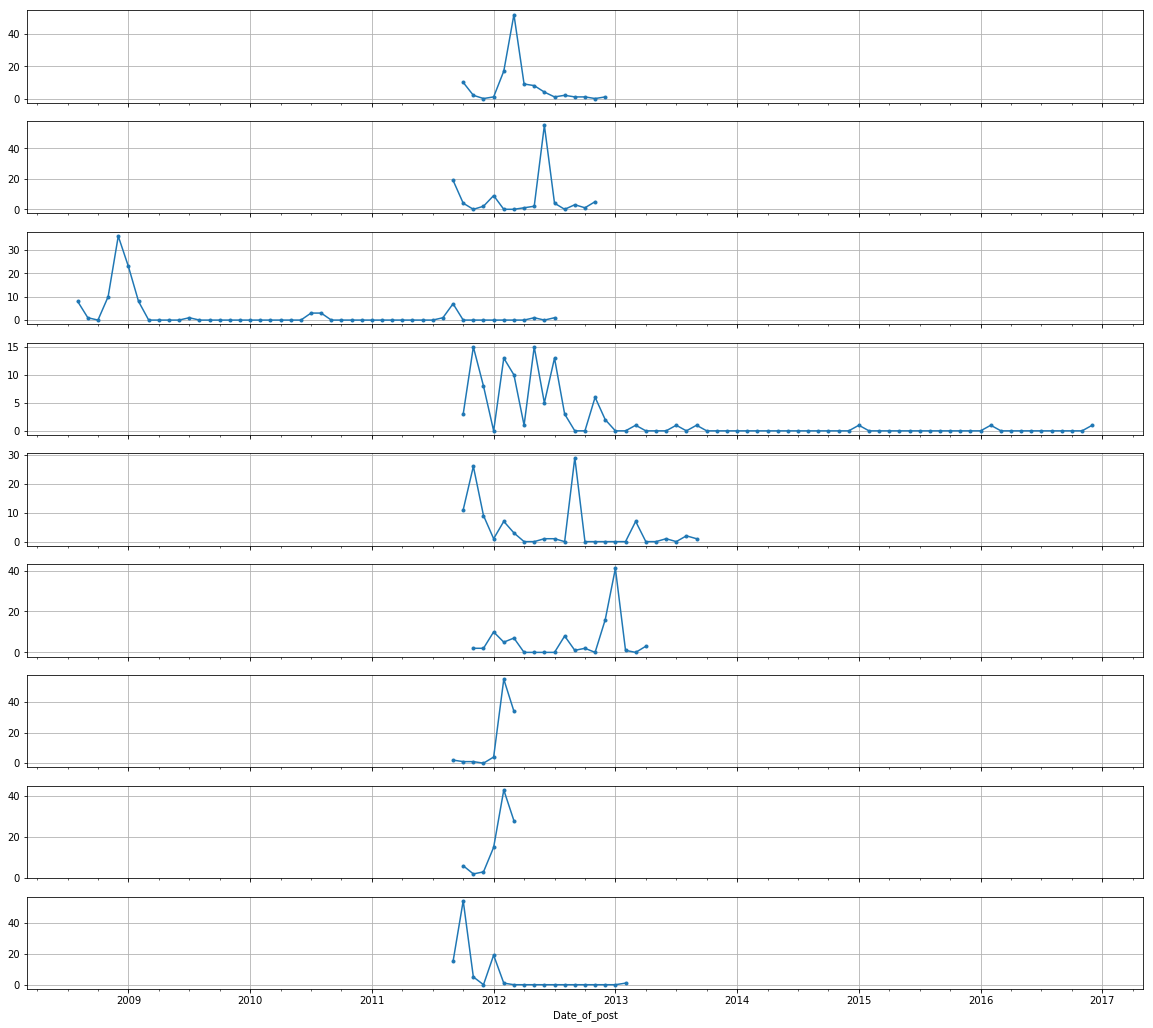

In [421]:
# look at what trajectories of the users closer to the 50th percentile (of posts) looked like


top_n = 9


plt.figure(num=None, figsize=(20, top_n*2), dpi=80, facecolor='w', edgecolor='k')


counter = 0

ax = [0]*top_n

for user_of_interest in remained_after_crisis.loc[remained_after_crisis['percentile_of_posts']>.50].head(top_n)['username']:
    ax[counter] = plt.subplot(top_n*100+11+counter)
    if counter > 0:
        ax[counter] = plt.subplot(top_n*100+11+counter,sharex=ax[0])
    users_posts = dataset.loc[dataset['Username']==user_of_interest,:].sort_values("Date_of_post")
    users_posts.groupby(pd.Grouper(key='Date_of_post',freq="1M")).count()['Username'].plot(marker='.')
    
    counter += 1 #### stopped editing here!
    plt.grid(True)
plt.show()


#### Who left during the crisis

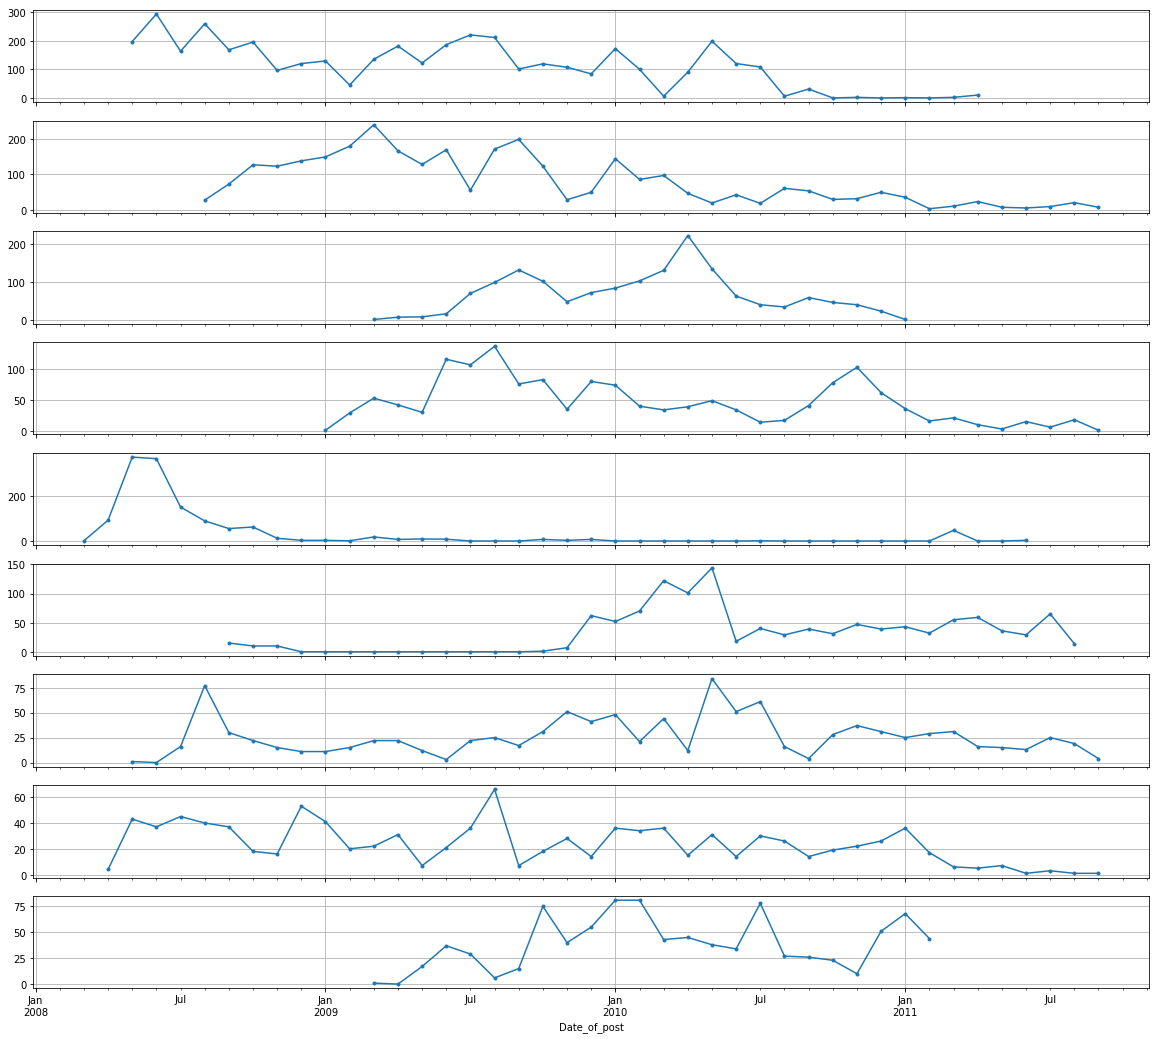

In [427]:
# top users


top_n = 9


plt.figure(num=None, figsize=(20, top_n*2), dpi=80, facecolor='w', edgecolor='k')


counter = 0

ax = [0]*top_n

for user_of_interest in left_during_crisis.head(top_n)['username']:
    ax[counter] = plt.subplot(top_n*100+11+counter)
    if counter > 0:
        ax[counter] = plt.subplot(top_n*100+11+counter,sharex=ax[0])
    users_posts = dataset.loc[dataset['Username']==user_of_interest,:].sort_values("Date_of_post")
    users_posts.groupby(pd.Grouper(key='Date_of_post',freq="1M")).count()['Username'].plot(marker='.')
    
    counter += 1 #### stopped editing here!
    plt.grid(True)
plt.show()


### Hypothesis / Finding
At least among these "super users" it appears as though those who "remained" after the crisis, were those who got more involved during the crisis itself. Those whose substantial involvement predates the crisis ended up leaving. 

This isn't as much a story of "who stayed and who left" as much as a story of replacement!

There is probably more to unpack here as well - why did the new people join and stay on?

It might indeed be helpful to do topic-modeling and see the distribution of topis over time.

To see if there are low-hanging fruit, as a first pass let's just use the metrics we have. With the LIWC data, and the selected "regular users", see if there are differences between people who left vs. stayed.

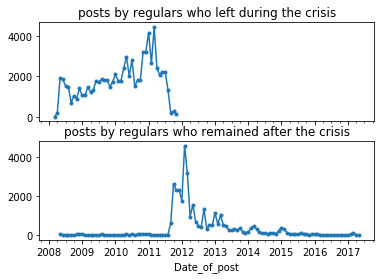

In [458]:
# Combine these graphs - look at the combined time-series for all the ppl who left vs. stayed.

ax = [0]*2

ax[0] = plt.subplot(211)
plt.title('posts by regulars who left during the crisis')

users_posts = dataset.loc[dataset['Username'].isin(left_during_crisis['username']),:].sort_values("Date_of_post")
users_posts.groupby(pd.Grouper(key='Date_of_post',freq="1M")).count()['Username'].plot(marker='.')

ax[1] = plt.subplot(212,sharex=ax[0])
plt.title('posts by regulars who remained after the crisis')

users_posts = dataset.loc[dataset['Username'].isin(remained_after_crisis['username']),:].sort_values("Date_of_post")
users_posts.groupby(pd.Grouper(key='Date_of_post',freq="1M")).count()['Username'].plot(marker='.')

plt.show()

This clearly shows that there was a "replacement" during the crisis - early regulars left, while nearly all the "regulars" who remained, largely began posting regularly during and after the crisis - when the prior group had left.

(In this case, "regulars" refers to users who posted in the sub-forumns at least 38 times, who consist of around 7% of unique contributors, but represent 75% of the posts in the community.)

Let's see if this trend is robust to a greater proportion of less frequent users.

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


left_during_crisis: 14212
remained_after_crisis: 1039
cutoff number of posts: 1
percent of posts represented: 1.0


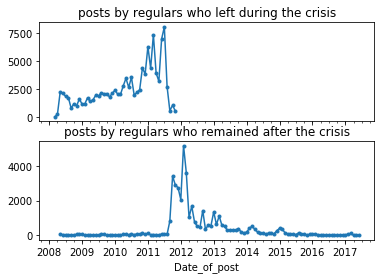

In [477]:
crisis_end = "2011-12-01" # posted before.... look at people who did not joing AFTER the crisis
crisis_start = "2011-01-01" # posted after.... look at ppl who did not leave BEFORE the crisis

users_of_interest2 = users_df_sorted.loc[(users_df_sorted['first_post']<crisis_end) & (users_df_sorted['last_post']>crisis_start)]


# re-calculate percentiles for these users

users_of_interest2['pct_of_posts'] = users_of_interest2['num_posts']/sum(users_of_interest2['num_posts'])
users_of_interest2['percentile_of_posts']= users_of_interest2['pct_of_posts'].cumsum()

cutoff = 1.00 # top percent of posts
regular_users2 = users_of_interest2.loc[users_of_interest2['percentile_of_posts'] < cutoff]

# regular_users

# plt.hist(regular_users['num_posts'],log=True)

left_during_crisis2 = regular_users2.loc[users_of_interest2['last_post']<crisis_end]
remained_after_crisis2 = regular_users2.loc[users_of_interest2['last_post']>=crisis_end]

print("left_during_crisis: "+ str(len(left_during_crisis2)))
print("remained_after_crisis: " + str( len(remained_after_crisis2)))
print("cutoff number of posts: "+ str(min(regular_users2['num_posts'])))
print("percent of posts represented: "+ str(cutoff))


# Combine these graphs - look at the combined time-series for all the ppl who left vs. stayed.

ax = [0]*2

ax[0] = plt.subplot(211)
plt.title('posts by users who left during the crisis')

users_posts = dataset.loc[dataset['Username'].isin(left_during_crisis2['username']),:].sort_values("Date_of_post")
users_posts.groupby(pd.Grouper(key='Date_of_post',freq="1M")).count()['Username'].plot(marker='.')

ax[1] = plt.subplot(212,sharex=ax[0])
plt.title('posts by users who remained after the crisis')

users_posts = dataset.loc[dataset['Username'].isin(remained_after_crisis2['username']),:].sort_values("Date_of_post")
users_posts.groupby(pd.Grouper(key='Date_of_post',freq="1M")).count()['Username'].plot(marker='.')

plt.show()

We see the same trend even when we do not filter out users with low contribution counts. (We still filter out users joined well after the crisis, or who quit well before the crisis started.)

Now, we see roughly _what_. But now, to the interesting question - WHY? Or, one might say, HOW?

It seems as if almost _everyone_ who joined before the crisis left, while almost _all_ of those who remained joined during the crisis itself.

If we were to predict whether someone would remain after the crisis, start-date may be the only factor we need to know.

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/pandas/core/internals.py:3462: FutureWarning: Passing in 'datetime64' dtype with no frequency is deprecated and will raise in a future version. Please pass in 'datetime64[ns]' instead.
  return self.apply('astype', dtype=dtype, **kwargs)
//anaconda/lib/python3.5/site-packages/ipykernel/__m

left_during_crisis: 793
remained_after_crisis: 304
cutoff number of posts: 21
percent of posts represented: 0.75


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


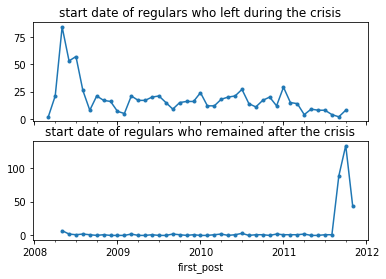

In [484]:
crisis_end = "2011-12-01" # posted before.... look at people who did not joing AFTER the crisis
crisis_start = "2011-01-01" # posted after.... look at ppl who did not leave BEFORE the crisis

users_of_interest2 = users_df_sorted.loc[(users_df_sorted['first_post']<crisis_end) & (users_df_sorted['last_post']>crisis_start)]


# re-calculate percentiles for these users

users_of_interest2['pct_of_posts'] = users_of_interest2['num_posts']/sum(users_of_interest2['num_posts'])
users_of_interest2['percentile_of_posts']= users_of_interest2['pct_of_posts'].cumsum()

cutoff = .750 # top percent of posts
regular_users2 = users_of_interest2.loc[users_of_interest2['percentile_of_posts'] < cutoff]

# regular_users

# plt.hist(regular_users['num_posts'],log=True)

left_during_crisis2 = regular_users2.loc[users_of_interest2['last_post']<crisis_end]
remained_after_crisis2 = regular_users2.loc[users_of_interest2['last_post']>=crisis_end]

print("left_during_crisis: "+ str(len(left_during_crisis2)))
print("remained_after_crisis: " + str( len(remained_after_crisis2)))
print("cutoff number of posts: "+ str(min(regular_users2['num_posts'])))
print("percent of posts represented: "+ str(cutoff))



try:
    left_during_crisis2["first_post"] = left_during_crisis2["first_post"].astype("datetime64")
    remained_after_crisis2["first_post"] = remained_after_crisis2["first_post"].astype("datetime64")
    
except:
    pass

# Combine these graphs - look at the combined time-series for all the ppl who left vs. stayed.

ax = [0]*2

ax[0] = plt.subplot(211)
plt.title('start date of regulars who left during the crisis')

# users_posts = dataset.loc[dataset['Username'].isin(left_during_crisis2['username']),:].sort_values("Date_of_post")
# users_posts.groupby(pd.Grouper(key='Date_of_post',freq="1M")).count()['Username'].plot(marker='.')

left_during_crisis2.groupby(pd.Grouper(key='first_post',freq="1M")).count()['username'].plot(marker='.')

ax[1] = plt.subplot(212,sharex=ax[0])
plt.title('start date of regulars who remained after the crisis')

# users_posts = dataset.loc[dataset['Username'].isin(remained_after_crisis2['username']),:].sort_values("Date_of_post")
# users_posts.groupby(pd.Grouper(key='Date_of_post',freq="1M")).count()['Username'].plot(marker='.')

remained_after_crisis2.groupby(pd.Grouper(key='first_post',freq="1M")).count()['username'].plot(marker='.')

plt.show()

This shows that those who posted after the crisis, largely _joined_ after the crisis. 

Should we compare the few people who joined earlier on and stayed with that great majority who left?

Maybe better to see what change in topics occured. Like doing topic detection in each time window - separately for the two different groups, and see if it is significantly different. Should not take _too_ long.

In [ ]:
# Look at the different LIWC stuff (over time) for each of the groups
